In [2]:
from sia.satellite import sentinel2
from sia.utils.helper import *
from sia.utils.raster import *
from sia.indices.indice import *
import os
import errno
from collections import defaultdict
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
s2 = sentinel2.Sentinel2()

# # s2_tile = '/home/ec2-user/SageMaker/sumit/crop-classification/unsupcc/satellite/satellite_tiles/s2_tile.shp'
# shape_file = 'data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp'
shape_file = '/Users/sumitmaan/work/dehaat/india_shapefile/districts/vaishali/file.shp'
pids = s2.get_product_ids('2021-11-01', '2021-12-31', 10, 5, 
                       shape_file=shape_file, bbox=None)

In [3]:
pids = {'2021-11-03': ['S2A_45RUJ_20211103_0_L2A'],
 '2021-11-08': ['S2B_45RUJ_20211108_0_L2A'],
 '2021-11-13': ['S2A_45RUJ_20211113_0_L2A'],
 '2021-11-18': ['S2B_45RUJ_20211118_0_L2A'],
 '2021-11-23': ['S2A_45RUJ_20211123_0_L2A'],
 '2021-11-28': ['S2B_45RUJ_20211128_0_L2A'],
 '2021-12-03': ['S2A_45RUJ_20211203_0_L2A'],
 '2021-12-08': ['S2B_45RUJ_20211208_0_L2A'],
 '2021-12-13': ['S2A_45RUJ_20211213_0_L2A']}

In [8]:
lst = [(key, val, shape_file) for key, val in pids.items()]

In [10]:
ig = Indice()

In [11]:
from multiprocessing import Pool, cpu_count, Process
pool = Pool(cpu_count()-2)
with pool:
    pool.map(ig.indices_generator, lst)

Indices are Generated at 2021-11-03


In [ ]:
# for key, val in pids.items():
    f_path = os.path.join('data', 'indice', str(key))
    try:
        os.makedirs(f_path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    raster_list = defaultdict(list)
    for item in val:
        raster_list['b4_path'].append(s2.pid_to_path(item, 'B04'))
        raster_list['b8_path'].append(s2.pid_to_path(item, 'B08'))
        raster_list['b8a_path'].append(s2.pid_to_path(item, 'B8A'))
        raster_list['b11_path'].append(s2.pid_to_path(item, 'B11'))
    
    b4_file = merge_clip_raster(raster_file_list=raster_list['b4_path'], output_file='b4.tif', shp_file=shape_file)
    b8_file = merge_clip_raster(raster_file_list=raster_list['b8_path'], output_file='b8.tif', shp_file=shape_file)
    
    b4 = raster_to_array(b4_file, 'int16')
    b8 = raster_to_array(b8_file, 'int16')
    ndvi = get_ndvi(b4,b8)
    ndvi = np.around(ndvi, decimals=2, out=None)
    write_raster('b4.tif', ndvi, f'{f_path}/ndvi.tif', gdal.GDT_Float32)
    
    savi = get_savi(b4, b8, 0.428)
    savi = np.around(savi, decimals=2, out=None)
    write_raster('b4.tif', savi, f'{f_path}/savi.tif', gdal.GDT_Float32)
    b4 = b8 = ndvi = savi = None
    
    b8a_file = merge_clip_raster(raster_file_list=raster_list['b8a_path'], output_file='b8a.tif', shp_file=shape_file)
    b11_file = merge_clip_raster(raster_file_list=raster_list['b11_path'], output_file='b11.tif', shp_file=shape_file)
    b8a = raster_to_array(b8a_file, 'int16')
    b11 = raster_to_array(b11_file, 'int16')
    
    lswi = get_lswi(b8a, b11)
    lswi = np.around(lswi, decimals=2, out=None)
    write_raster('b8a.tif', lswi, f'{f_path}/lswi.tif', gdal.GDT_Float32)
    b8a = b11 = lswi = None

In [15]:
def merge_clip_raster(raster_file_list, output_file=None, shp_file=None, bbox=None, out_width=None, out_height=None):
    ds_lst = list()
    for raster in raster_file_list:
        ds = gdal.Warp('', raster, format='vrt', dstNodata=0,
                       dstSRS="+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
                       cutlineDSName=shp_file, cropToCutline=True, width=out_width, height=out_height)
        ds_lst.append(ds)
    del ds
    if shp_file:
        ds = gdal.BuildVRT('', ds_lst, VRTNodata=0, srcNodata=0)
        gdal.Warp(output_file, ds, format='GTiff', dstNodata=0,
                  dstSRS="+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
                  cutlineDSName=shp_file, cropToCutline=True, width=out_width, height=out_height)
    else:
        if out_width:
            ds = gdal.BuildVRT('', ds_lst, VRTNodata=0, srcNodata=0)
            gdal.Warp(output_file, ds, format='GTiff', dstNodata=0,
                      dstSRS="+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
                      outputBounds=tuple(bbox), cropToCutline=True, width=out_width, height=out_height)
        else:
            ds = gdal.BuildVRT('', ds_lst, VRTNodata=0, srcNodata=0)
            gdal.Warp(output_file, ds, format='GTiff', dstNodata=0,
                      dstSRS="+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
                      outputBounds=tuple(bbox), cropToCutline=True)
    return output_file

In [16]:
merge_clip_raster(['vaishali.img'], output_file='data/agrimask/vaishali.tif', shp_file=shape_file, out_height=5607, out_width=6111)

'data/agrimask/vaishali.tif'

In [5]:
os.makedirs('data/agrimask')

In [ ]:
from glob import glob
files = glob('data/file/indices/2021-11-03/ndvi.tif

In [29]:
arr = raster_to_array('vaishali.img', data_type='int64')
arr1 = raster_to_array('data/file/indices/2021-11-03/ndvi.tif', data_type='float')

In [30]:
arr.shape, arr1.shape

((5787, 6560), (5607, 6111))

In [31]:
import matplotlib.pyplot as plt

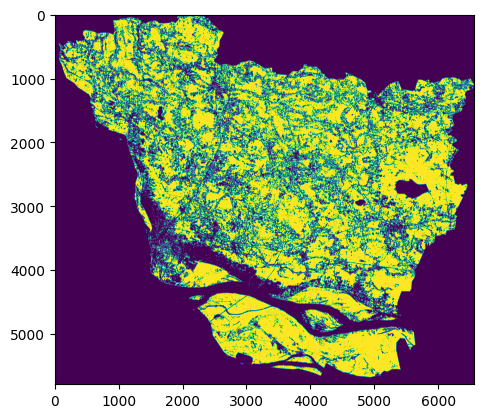

In [32]:
plt.imshow(arr)

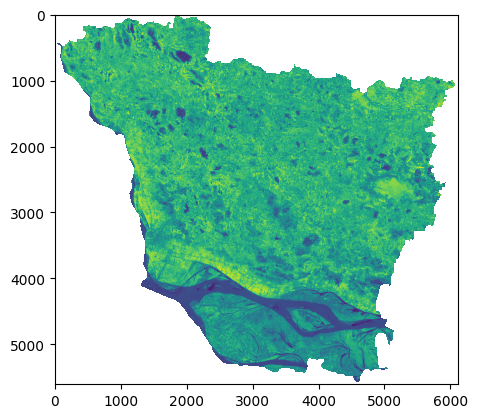

In [33]:
plt.imshow(arr1)

In [34]:
arr1[arr==0] = 0

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5607 but corresponding boolean dimension is 5787

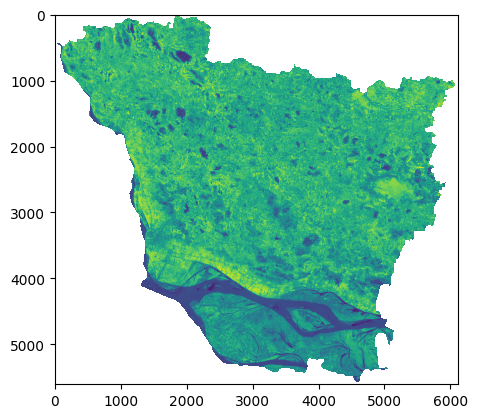

In [35]:
plt.imshow(arr1)